In [1]:
import os
import torch
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
base_path = 'CIFAR10_dirichlet0.05_12'
dirs = [os.path.join(base_path, d, base_path, 'train_data.pth') for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

In [3]:
labels = {}
for file in dirs:
    with open(file, 'rb') as f:
        dataset = pickle.load(f)
        key = file.split('/')[1]
        labels[key] = []
        for data in dataset:
            labels[key].append(data[1])

labels = {k: labels[k] for k in sorted(labels.keys(), key=lambda x: int(x.split('_')[1]))}

What is the label distribution (class) imbalance per client

In [12]:
for part, lbls in labels.items():
    unique, counts = np.unique(lbls, return_counts=True)
    total = len(lbls)
    percentages = {int(u): round(100 * c / total, 2) for u, c in zip(unique, counts)}
    print(f"{part}: {percentages}")

part_0: {0: 59.97, 1: 3.54, 4: 2.8, 5: 21.16, 8: 12.52}
part_1: {1: 87.95, 4: 9.35, 8: 0.02, 9: 2.68}
part_2: {2: 34.33, 6: 65.67}
part_3: {4: 14.17, 5: 32.92, 8: 5.42, 9: 47.5}
part_4: {1: 89.09, 6: 8.89, 9: 2.02}
part_5: {7: 100.0}
part_6: {2: 0.63, 4: 0.03, 5: 99.35}
part_7: {0: 41.97, 1: 5.67, 2: 44.86, 4: 0.02, 6: 0.04, 7: 6.21, 9: 1.24}
part_8: {4: 100.0}
part_9: {4: 0.11, 8: 99.89}
part_10: {4: 0.02, 8: 0.66, 9: 99.32}
part_11: {1: 0.39, 2: 0.1, 3: 98.72, 4: 0.02, 6: 0.39, 7: 0.02, 8: 0.34, 9: 0.02}


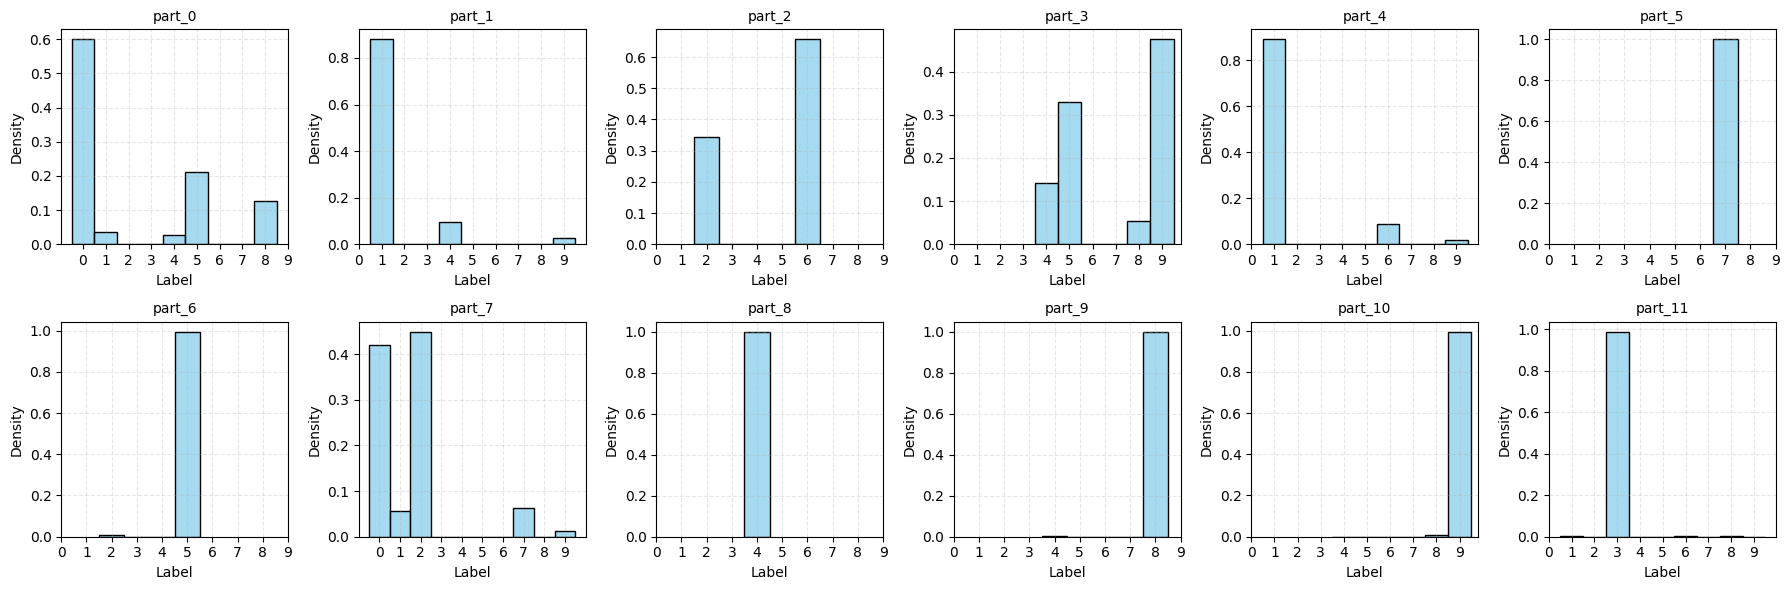

In [ ]:
num_parts = len(labels)
fig, axes = plt.subplots(2, 6, figsize=(18, 6)) 
axes = axes.flatten()  # Flatten to easily index with a loop

for idx, (part, lbls) in enumerate(labels.items()):
    ax = axes[idx]
    
    # Plot histogram + KDE on this axis
    sns.histplot(lbls, bins=range(11), stat='density', discrete=True, color='skyblue',
                 edgecolor='black', ax=ax)

    ax.set_title(f'{part}', fontsize=15)
    ax.set_xlabel('Label')
    ax.set_ylabel('Density')
    ax.set_xticks(range(10))
    ax.grid(True, linestyle='--', alpha=0.3)

# Hide any unused subplots
for i in range(num_parts, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

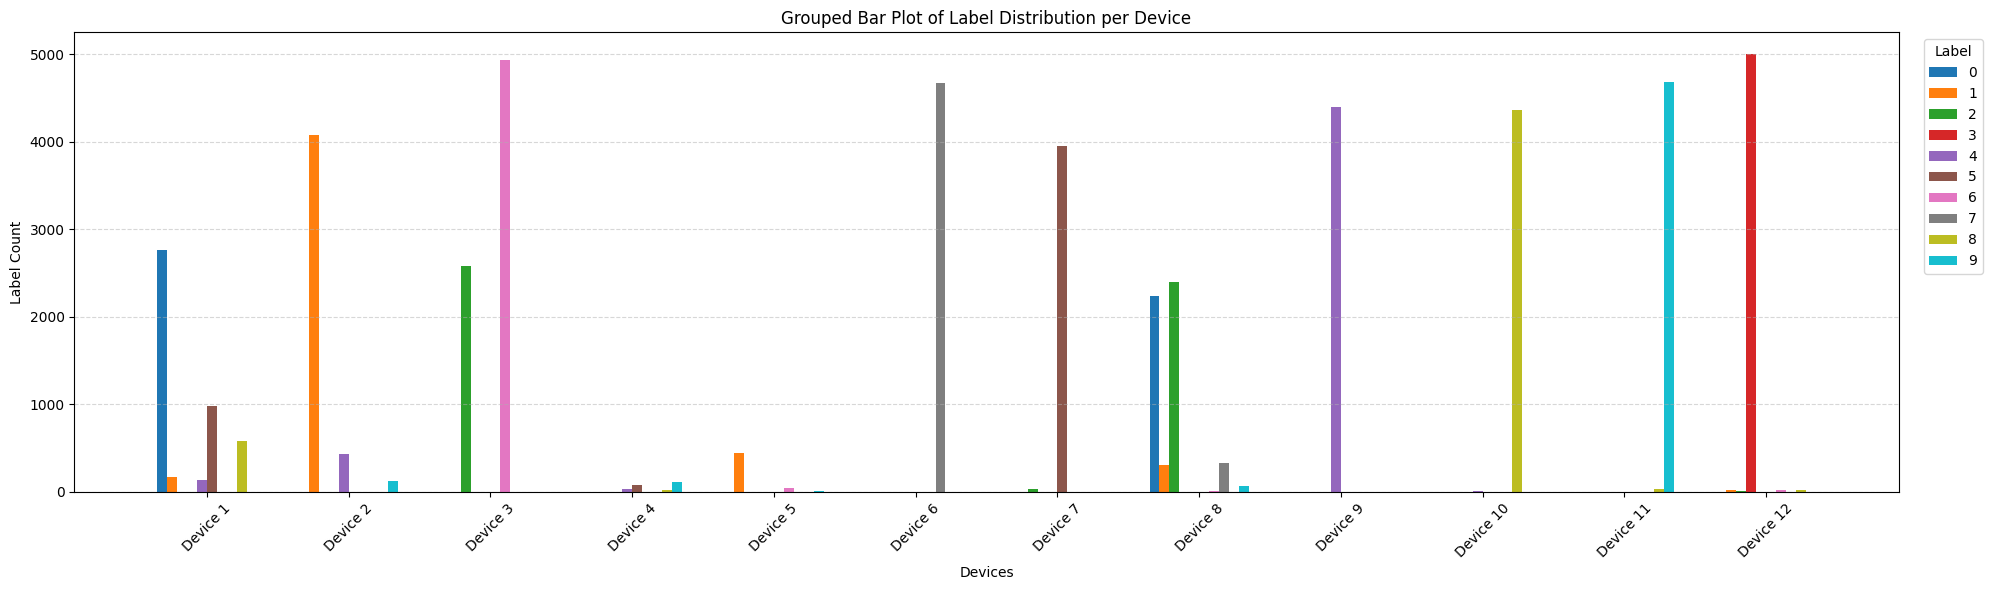

In [ ]:
# Prepare data
device_names = [f'Device {i+1}' for i in range(len(labels))]
label_ids = np.arange(10)  # Labels 0–9

# Create a matrix: rows = devices, cols = label counts (0–9)
label_matrix = np.zeros((len(labels), 10), dtype=int)

for i, (_, lbls) in enumerate(labels.items()):
    counts = np.bincount(lbls, minlength=10)
    label_matrix[i, :] = counts

# Plot
bar_width = 0.07
x = np.arange(len(labels))  # positions for device groups

# Extended figure for clarity
fig, ax = plt.subplots(figsize=(20, 6))

colors = plt.cm.tab10.colors  # consistent 10-color palette

# Plot bars for each label (0 to 9)
for i in range(10):
    ax.bar(x + i * bar_width, label_matrix[:, i], width=bar_width, color=colors[i], label=str(i))

# Labeling
ax.set_xticks(x + 4.5 * bar_width)
ax.set_xticklabels(device_names, rotation=45)
ax.set_xlabel('Devices')
ax.set_ylabel('Label Count')
ax.set_title('Grouped Bar Plot of Label Distribution per Device')
ax.legend(title='Label', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


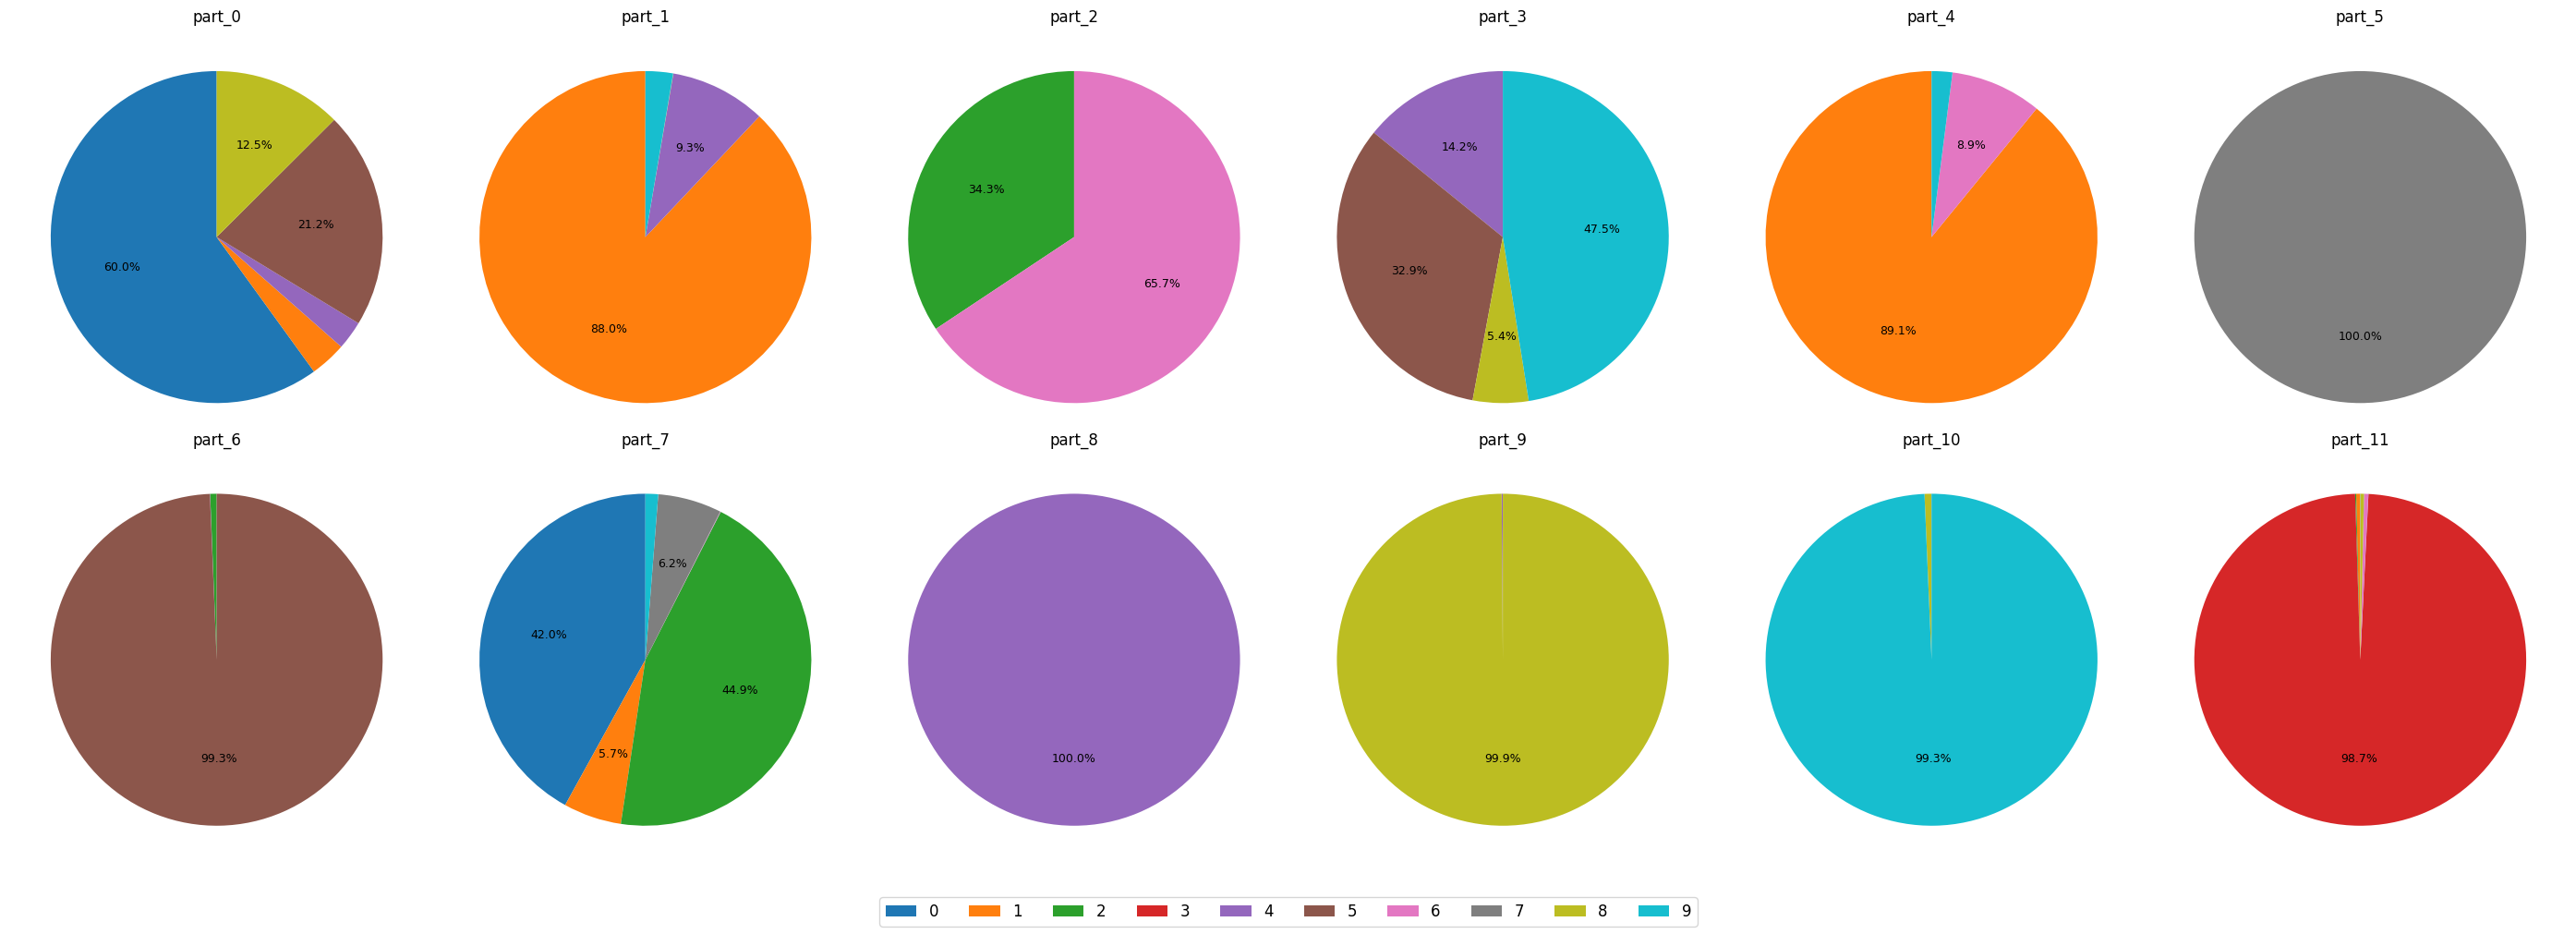

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# Setup
label_names = [str(i) for i in range(10)]
colors = plt.cm.tab10.colors  # consistent 10-color palette

fig, axes = plt.subplots(2, 6, figsize=(28, 10))
axes = axes.flatten()

for idx, (part, lbls) in enumerate(labels.items()):
    ax = axes[idx]
    counts = np.bincount(lbls, minlength=10)
    
    # Filter to show only labels that exist
    values = [count for count in counts if count > 0]
    value_labels = [label_names[i] for i, count in enumerate(counts) if count > 0]
    slice_colors = [colors[i] for i, count in enumerate(counts) if count > 0]

    def autopct_filter(pct):
        return f'{pct:.1f}%' if pct > 5 else ''  # only show >5% for clarity

    wedges, texts, autotexts = ax.pie(
        values,
        labels=None,  # no text labels to reduce clutter
        autopct=autopct_filter,
        colors=slice_colors,
        startangle=90,
        textprops={'fontsize': 9}
    )
    
    ax.set_title(f'{part}', fontsize=12)

# Remove unused axes
for i in range(len(labels), len(axes)):
    fig.delaxes(axes[i])

# Shared legend
legend_elements = [Patch(facecolor=colors[i], label=label_names[i]) for i in range(10)]
fig.legend(handles=legend_elements, loc='lower center', ncol=10, fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


How many samples does each client have?

In [21]:
import pandas as pd

# Prepare data for the table
table_data = []
for part, lbls in labels.items():
    counts = np.bincount(lbls, minlength=10)
    row = {'part': part}
    for label in range(10):
        row[str(label)] = counts[label]
    table_data.append(row)

# Create DataFrame
df_counts = pd.DataFrame(table_data)
df_counts = df_counts.rename(columns={str(i): f'Class {i}' for i in range(10)})
df_counts = df_counts.rename(columns={'part': 'Device'})
df_counts['Device'] = range(1, len(df_counts) + 1)
df_counts = df_counts.set_index('Device')
display(df_counts)

,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9
Device,,,,,,,,,,
1,2763,163,0,0,129,975,0,0,577,0
2,0,4074,0,0,433,0,0,0,1,124
3,0,0,2579,0,0,0,4934,0,0,0
4,0,0,0,0,34,79,0,0,13,114
5,0,441,0,0,0,0,44,0,0,10
6,0,0,0,0,0,0,0,4668,0,0
7,0,0,25,0,1,3946,0,0,0,0
8,2237,302,2391,0,1,0,2,331,0,66
9,0,0,0,0,4395,0,0,0,0,0


**Data Size Differences (Total Samples per Device)**

✅ Observation:
1. Devices 4 and 5 have very small datasets (<< 1000).
2. Devices 3 and 8 have significantly larger datasets (>> 7000).
3. Most others are in the range of 4,000–5,000.

Conclusion: There is a notable imbalance in the number of samples per client.

**Class Diversity Differences (Number of Classes Present per Device)**
✅ Observation:
1. Devices 6, 9, 10 are nearly single-class clients.
2. Devices 1, 8, 12 have broad label diversity (6–7 classes).

Conclusion: There is high variation in class distributions across clients — many clients are highly label-skewed.


***This indicates a non-IID distribution of data, which is a key challenge in federated learning scenarios.***